# Estimating storage requirements

Applications which depend on high-resolution, spatiotemporal data can potentially have high data storage requirements. The storage requirements are one of the primary factors that drive the cost of deployment and execution of the Software as a Service (SaaS).

To some extent the required storage (and cost) is co-dependent with the application requirements. I.e. the cost of various options may inform whether we choose to take them on and visa-versa; what exactly the application does will affect the ongoing costs.

There are a number of factors that affect the data requirements:

* Spatial resolution and domain
* Number of timesteps/timescales
* Number of variables
* Number of models

In general, the data requirements grows as a product of all of these factors and a linear increase in one factor will result in a linear increase in the cost. Time and space resolution options both grow somewhat exponentially, so likewise the cost can grow as such based on the options selected. There can be several orders of magnitude differences between conservative choices and more full-featured choices.

Let's explore some of the options.

In [1]:
import sys

sys.path.append('../util')

import numpy as np
from matplotlib import pyplot as plt, ticker
import matplotlib.patheffects as path_effects
from mpl_toolkits.mplot3d import Axes3D

pe = [path_effects.Stroke(linewidth=2, foreground='black'), path_effects.Normal()]

timescales = {
    # Number of time steps in the series for a given time scale
    'climatological': 17, # monthly, seasonal, annual means over the whole time period
    'seasonal': 5 * 150, # four seasons + an annual mean
    'annual': 150, # 1950 - 2100
    'monthly': 12 * 150,
    'daily': 365 * 150 # approximately
}

%matplotlib inline

Let's start by enumerating some of the sets of options that we would be considering. We'll assume that all numbers are stored as 32-bit IEEE floating point numbers.

In [2]:
sizeof_float = 4

Let's consider the range of grid sizes from a low resolution (250 km / grid cell) global GCM, up to the high-resolution (400 m / grid cell) grid over BC. The BC PRISM grid represents the largest grid that we commonly use.

In [3]:
spatial = np.array((128 * 64, 128 * 256, 510 * 1068, 1680 * 3241))

Our range of variables doesn't vary much. Either we're just using minimum/maximum temperature and precipitation (3 variables), or we're including a few other derived variables (7 variables).

In [4]:
variables = np.array((3, 7))

Time ranges vary quite widely. On the low-end, if we only store climatological data (i.e. 30 year averages), we only store 17 timesteps: an annual mean, 4 seasonal means, and 12 monthly means. Other options include, an annual timeseries, monthly timeseries, daily timeseries. A daily timeseries includes about 55 thousand timesteps, so that essentially multiplies the data requirements by a factor of 3000.

In [5]:
timesteps = np.array(sorted(list(timescales.values())))

There are many global climate modelling agencies and a number of scenarios that are modeled. One could only include analysis for a small number of them (17 is probably the low end), or up to a few hundred. I've capped it at 250.

In [6]:
models = np.array([17, 28, 90, 250])

So the full range of options looks something like the set below. That'a lot of options, so I'll run through a few scenarios where I fix two variables, and vary the other two, to look and where a good tradeoff could be.

In [7]:
print(spatial)
print(variables)
print(timesteps)
print(models)

[   8192   32768  544680 5444880]
[3 7]
[   17   150   750  1800 54750]
[ 17  28  90 250]


## The budget scenario

If we only consider using 3 variables (tmin, tmax, precip), and only allowing analysis with climatological values, then the data requirements are acutally really minimal and essentially cost tens of dollars per year (!). Limiting to climatological values gives us the latitude to use a high spatial resolution and consider pretty much the full range of models that are available, and *still* be insanely inexpensive.

This is the closest scenario that we have to how the present [Regional Analysis Tool](http://www.pacificclimate.org/analysis-tools/regional-analysis-tool) works.

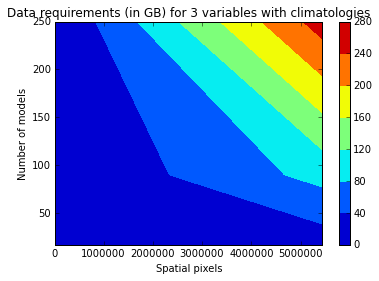

In [8]:
# 3 variables at climatological scale
x = spatial
y = models
xx, yy = np.meshgrid(x, y)
z = xx * yy * 3 * 17 * sizeof_float / (2 ** 30)
plt.contourf(x,y,z)
plt.xlabel("Spatial pixels")
plt.ylabel("Number of models")
plt.title("Data requirements (in GB) for 3 variables with climatologies")
plt.colorbar()

### Costs

For all of these scenarios, I'll estimate costs by multiplying by Amazon's rate for S3 reduced redundancy storage. Reduced redundancy is appropriate, because all of this bulk data is stored elsewhere and is reproducible with relative ease. It does not need to be backed up; it just needs to be live for the application to hit it.

S3 Reduced Redundancy is priced at \$0.024 per GB per month for data volumes under 1 TB. It's *slightly* less for > 1 TB, but I'll just use a static scaling factor to keep it simple. One could use a different scaling factor to estimate other provider options (e.g. \$2.44 / GB / month for the government servers).

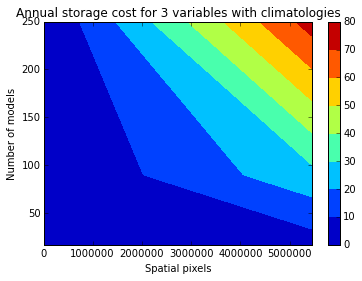

In [9]:
cost = z * 12 * .024
plt.contourf(x,y,cost)
plt.xlabel("Spatial pixels")
plt.ylabel("Number of models")
plt.title("Annual storage cost for 3 variables with climatologies")
plt.colorbar()

## High spatial resolution, low variables

Let's assume that we want to work at a high spatial resolution. Infrastructure engineering projects are usually very site specific (a bridge, a dam, a ferry dock), so we'll usually be interested in the fine scale.

We'll consider the full range of models available, and timescales up to a monthly timeseries (i.e. not daily, because then things get ridiculous). If you *do* want an off-the cuff estimate for daily, just multiply the top Y range by 30.

Half of the chart is still under 10 TB, but the data requirements get bigger quickly as you consider more timescales. For example, once you get above seasonal data into monthly, one could be storing as much as 20+ TB of data.

The storage costs for these options range from $1-8k / year, so it's still very reasonable for the value that the data provide.

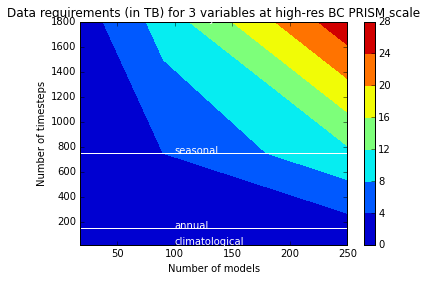

In [10]:
# 3 variables at high-res BC prism scale
x = models
y = timesteps[:-1]
xx, yy = np.meshgrid(x, y)
z = xx * yy * 3 * 5444880 * sizeof_float / (2 ** 40)
plt.contourf(x,y,z)
plt.xlabel("Number of models")
plt.ylabel("Number of timesteps")
plt.title("Data requirements (in TB) for 3 variables at high-res BC PRISM scale")
for key, val in timescales.items():
    if val <= 1800:
        plt.axhline(val, color='white', label=key)
        plt.text(100, val, key, color='white', path_effects=pe)

plt.colorbar()

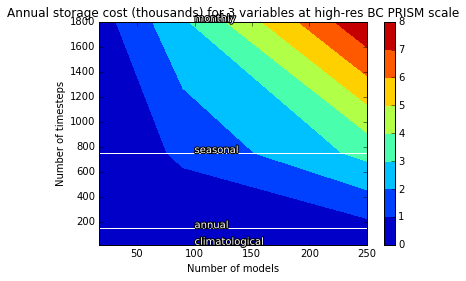

In [11]:
cost = z * 1024 * 12 * .024 / 1000
plt.contourf(x,y,cost)
plt.xlabel("Number of models")
plt.ylabel("Number of timesteps")
plt.title("Annual storage cost (thousands) for 3 variables at high-res BC PRISM scale")
for key, val in timescales.items():
    if val <= 1800:
        plt.axhline(val, color='white', label=key)
        plt.text(100, val, key, color='white', path_effects=pe)
plt.colorbar()

## All models all dervived variables

Things get interesting when you start to consider the full range of variables, the full range of models and daily data. And by "interesting", I mean expensive.

The costs are pretty reasonable below the monthly timescale, but including daily puts the data requirements into the Petabytes range. Note the log scale on both axes and the colorbar.

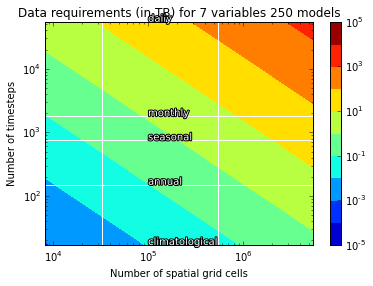

In [12]:
# 7 derived variables for all 250 models
x = spatial
y = timesteps
xx, yy = np.meshgrid(x, y)
z = xx * yy * 7 * 250 * sizeof_float / (2 ** 40)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
img = ax.contourf(x,y,z, locator=ticker.LogLocator())

ax.set_yscale('log')
ax.set_xscale('log')

plt.xlabel("Number of spatial grid cells")
plt.ylabel("Number of timesteps")
plt.title("Data requirements (in TB) for 7 variables 250 models")
for key, val in timescales.items():
    ax.axhline(val, color='white', label=key)
    ax.text(10**5, val, key, color='white', path_effects=pe)
for val in spatial:
    ax.axvline(val, color='white')
    
fig.colorbar(img)

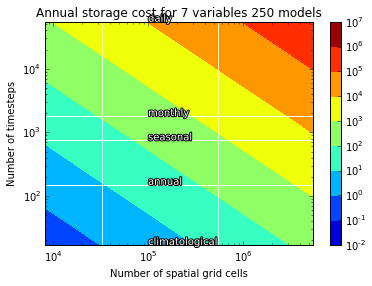

In [13]:
cost = z * 1024 * 12 * .024

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
img = ax.contourf(x,y,cost, locator=ticker.LogLocator())

plt.xlabel("Number of spatial grid cells")
plt.ylabel("Number of timesteps")
plt.title("Annual storage cost for 7 variables 250 models")

ax.set_yscale('log')
ax.set_xscale('log')

for key, val in timescales.items():
    ax.axhline(val, color='white', label=key)
    text = ax.text(10**5, val, key, color='white', path_effects=pe)
for val in spatial:
    ax.axvline(val, color='white')

plt.colorbar(img)

Note that annual storage costs on the high end of the spectrum run into the millions.

## Using ClimDEX to simulate extremes

One feasible alternative to storing dailiy climate model output is to precompute the ClimDEX indices and then commit to using only them for questions about extreme climate behaviour. The number of variables would be increased to somewhere around 38 (31 climdex + 3 fundamental + 4 derived). But the temporal scale would be limited to no more than monthly.

The calculation is a little more involved because some indices are monthly and some are annual and some are both. Let's say that there are 31 annual, and 11 are both monthly *and* annual. We'll fix the timescale and number of variables and evaluate the options for spatial grid and number of models.

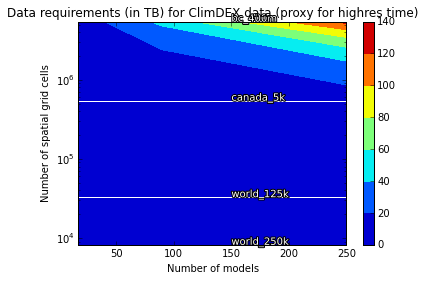

In [14]:
# 7 derived variables for all 250 models
x = models
y = spatial
xx, yy = np.meshgrid(x, y)
z = xx * yy * (7 * 150 + 31 * 150 + 11 * 1800) * sizeof_float / (2 ** 40)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_yscale('log')
img = ax.contourf(x,y,z)

plt.xlabel("Number of models")
plt.ylabel("Number of spatial grid cells")
plt.title("Data requirements (in TB) for ClimDEX data (proxy for highres time)")
for val in spatial:
    ax.axhline(val, color='white')
ax.text(150, 128 * 64, 'world_250k', color='white', path_effects=pe)
ax.text(150, 128 * 256, 'world_125k', color='white', path_effects=pe)
ax.text(150, 510 * 1068, 'canada_5k', color='white', path_effects=pe)
ax.text(150, 1680 * 3241, 'bc_400m', color='white', path_effects=pe)
    
fig.colorbar(img)

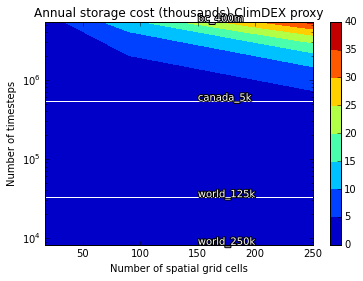

In [15]:
cost = z * 1024 * 12 * .024 / 1000
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_yscale('log')

img = ax.contourf(x,y,cost)
plt.xlabel("Number of spatial grid cells")
plt.ylabel("Number of timesteps")
plt.title("Annual storage cost (thousands) ClimDEX proxy")
fig.colorbar(img)

for val in spatial:
    ax.axhline(val, color='white')
path_effects = [path_effects.Stroke(linewidth=2, foreground='black'), path_effects.Normal()]
ax.text(150, 128 * 64, 'world_250k', color='white', path_effects=pe)
ax.text(150, 128 * 256, 'world_125k', color='white', path_effects=pe)
ax.text(150, 510 * 1068, 'canada_5k', color='white', path_effects=pe)
ax.text(150, 1680 * 3241, 'bc_400m', color='white', path_effects=pe)
    

So we can pretty much do all of Canada at 5km scale for under $5,000 / year if we assume that it's ClimDEX is already precomputed (or we include that as a one-time cost somewhere else).